In [19]:
import sqlite3
import glob
import urllib.parse
import records
import requests
from bs4 import BeautifulSoup
import MeCab as mc
import re
from collections import Counter
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# import sqlite3litedatastore as datastore

In [3]:
conn = None

# データベースに接続する
def connect():
    global conn
    conn = sqlite3.connect("./sample.db")
    
# コネクションを断つ
def close():
    conn.close()
    
# テーブル作成
def create_table():
    # DROPは消す.
    conn.execute("DROP TABLE IF EXISTS countries")
    conn.execute("""CREATE TABLE countries (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            country_name TEXT,
            content TEXT
    )""")
    
# loadは積むという意味
def load(name, content):
    conn.execute(
        "INSERT INTO Countries (country_name, content) VALUES (?,?)", (name, content))
    conn.commit()
    
def get(doc_id, fl):
    row_ls = conn.execute(
        "SELECT {} FROM docs WHERE id = ?".format(",".join(fl)),(doc_id,)).fetchone()
    row_dict = {}
    for key, value in zip(fl, row_ls):
        row_dict[key] = value
    return row_dict

def get_all_ids(limit, offset=0):
    return [record[0] for record in conn.execute("SELECT id FROM docs LIMIT ? OFFSET ?",(limit, offset))]

In [4]:
url = "https://ja.wikipedia.org"
r = requests.get(url+"/wiki/国の一覧")

html_soup = BeautifulSoup(r.text, "html.parser")
table = html_soup.find("table",class_= "wikitable")
connect()
create_table()

for tr in table.find_all("tr"):
    link = tr.find_all("a")
    if link:
        country_name = link[1].text
        country_link = link[1].get("href")
        
        res = requests.get(url+country_link)
        load(country_name,res.text)
close()

In [98]:
con = None
con = sqlite3.connect("./sample.db")
cursor = con.cursor()
map_in=input()
res = cursor.execute("SELECT content FROM Countries WHERE country_name = ?",[map_in])
# print(res)
# bs = BeautifulSoup(cursor.fetchall()[0][0],"html.parser")
bs = BeautifulSoup(cursor.fetchone()[0],"html.parser")

インドネシア共和国


In [132]:
# print(bs.find("div", id = "content").text)
div_all = bs.find("div", id = "content").text
# print(re.sub("[\n,\xa0^,\<http\S*]","",div_all))
del_n = re.sub("[\n,\xa0^]","",div_all)
del_wiki = re.sub("出典|編集|参照|ページ|cs|閲覧|wiki[pm]edia|parser|CentralStatistiOffice|font|url|commons|alt|svg","",del_n)
del_wiki2 = re.sub("left|background|kern|km|right|emcenter|position|upload|output|thumb|mw|png|inherit|org|px|citation","",del_wiki)
del_wiki3 = re.sub("emcenter|repeat|それ|一覧|略称|以上|こと|表記|もの|記事|以下|ため|直接|出版|構成|ほか|これ|よう","",del_wiki2)
del_all = re.sub("https?\S*\s","",del_wiki3)
del_space = re.sub(" ","",del_all)
# print(del_space)

In [11]:
# tagger = mc.Tagger("-Ochasen")
tagger = mc.Tagger("-d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd")

text = "新国立美術館"
node = tagger.parse(text)
print(node)

新国立美術館	名詞,固有名詞,一般,*,*,*,新国立美術館,シンコクリツビジュツカン,シンコクリツビジュツカン
EOS



In [133]:
def mecab_analysis(texts):
    t = mc.Tagger("")
    t.parse('')
    output = []
    node =  t.parseToNode(texts)  
    while node:
        if node.surface != "":  # ヘッダとフッタを除外
            word_type = node.feature.split(",")[0]
            if word_type in ['名詞', '形容詞']:
                output.append(node.surface)
        node = node.next
        if node is None:
            break
    return output

In [134]:
text = " ".join(mecab_analysis(del_space))

In [139]:
fpath = "/home/t-katou/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf"
wordcloud = WordCloud(
    background_color="white",
    font_path=fpath,
    width=800,
    collocations = False,
    max_words=70,
    height=600).generate(text)

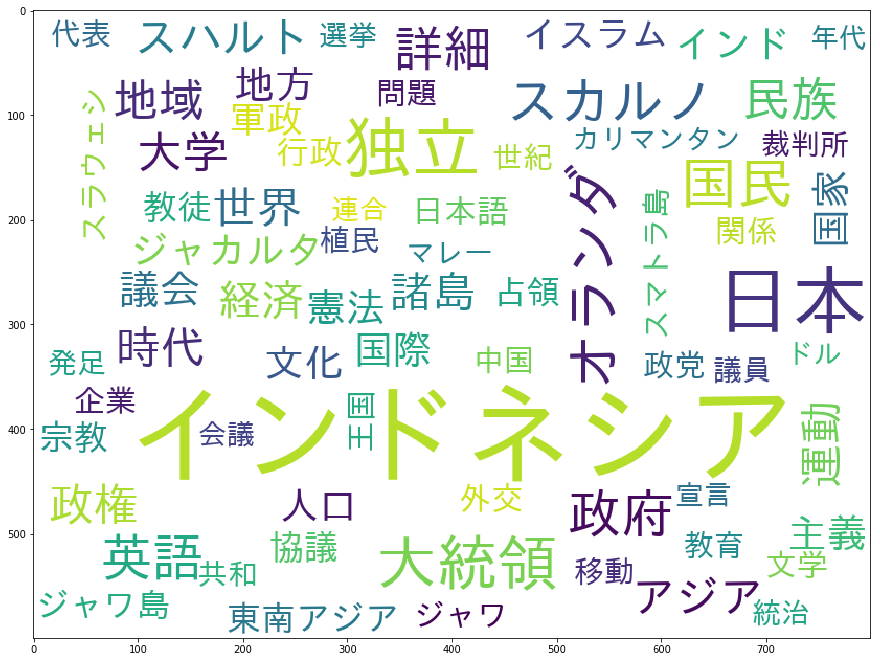

In [140]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
# wordcloud.to_image("aaa.png")

In [66]:
import matplotlib as mpl
print(mpl.matplotlib_fname())

/home/t-katou/.local/lib/python3.6/site-packages/matplotlib/mpl-data/matplotlibrc


In [41]:
Counter(mecab_analysis(del_space))
sorted(Counter(mecab_analysis(del_space)).items(),key=lambda x:x[1],reverse=True)

[('.', 248),
 ('-', 148),
 ('アゼルバイジャン', 122),
 ('年', 82),
 ('[', 79),
 ('1', 73),
 ('日', 53),
 ('|', 53),
 ('e', 52),
 ('国', 49),
 (':', 47),
 ('2017', 47),
 ('a', 46),
 ('o', 44),
 ('r', 43),
 (']', 41),
 ('月', 39),
 ('編集', 38),
 ('i', 38),
 ('人', 35),
 ('3', 35),
 ('t', 35),
 ('2', 34),
 ('/', 34),
 ('共和', 32),
 ('iyun', 32),
 ('英語', 31),
 ('閲覧', 30),
 ('www', 30),
 ('(', 29),
 ('n', 29),
 ('版', 28),
 (']。', 27),
 ('18', 27),
 ('s', 25),
 ('参照', 25),
 ('com', 24),
 ('mw', 22),
 ('parser', 22),
 ('地域', 21),
 ('5', 21),
 ('時点', 21),
 ('6', 20),
 ('output', 20),
 ('cs', 20),
 ('4', 19),
 ('詳細', 19),
 ('オリジナル', 19),
 ('アーカイブ', 19),
 ('独立', 18),
 ('語', 18),
 ('大統領', 18),
 ('バクー', 17),
 ('ロシア', 17),
 ('アルメニア', 17),
 ('7', 17),
 ('9', 17),
 ('u', 17),
 ('者', 15),
 ('{', 15),
 ('2016', 14),
 ('10', 14),
 ('b', 14),
 ('l', 14),
 ('－', 14),
 ('A', 13),
 ('ヨーロッパ', 13),
 ('地方', 13),
 ('的', 13),
 ('19', 13),
 (')', 12),
 ('世界', 12),
 ('12', 12),
 (').', 12),
 ('c', 12),
 ('イラン', 11),
 ('8', 11),


In [57]:
# a = ["い","あ","う"]
# print(" ".join(a))
mecab_sorted=sorted(Counter(mecab_analysis(del_space)).items(),key=lambda x:x[1],reverse=True)
# print(mecab_sorted[0][0])
list = []

for str in mecab_sorted:
    list.append(str[0])
    
# print(list)
rennketu=" ".join(list)
print(rennketu)

. - アゼルバイジャン 年 [ 1 日 | e 国 : 2017 a o r ] 月 編集 i 人 3 t 2 / 共和 iyun 英語 閲覧 www ( n 版 ]。 18 s 参照 com mw parser 地域 5 時点 6 output cs 4 詳細 オリジナル アーカイブ 独立 語 大統領 バクー ロシア アルメニア 7 9 u 者 { 2016 10 b l － A ヨーロッパ 地方 的 19 ) 世界 12 ). c イラン 8 国際 ナゴルノ・カラバフ 南 国家 経済 m ][ 家 ; 2015 こと 自治 観光 民族 スポーツ 朝 イスラム T }. f h z ソビエト 上 25 選手 歌手 background 政府 km 人口 事実 北 カスピ海 政治 科学 11 ワイン 加盟 svg % 連邦 ジョージア 文化 州 支配 世紀 多く アゼリー d 開催 作曲 org right S 記事 時代 主義 位 ドル 状態 トルコ 紛争 国民 音楽 文学 遺産 関係 系 川 後 ほか ]、 国内 2019 v バレーボール 2018 F R Lock .“ C p j theguardian アジア 項目 領 アーザルバーイジャーン Az 首都 イルハム・アリエフ 面積 0 GDP 1991 az 東 西 歴史 区分 地理 交通 宗教 出身 リンク 日本語 下 派 17 同国 カザフスタン 空港 節 大会 ' リーグ UEFA & citation inherit 呼び出し エラー accessdate w k 話 編 歴 諸島 分類 圏 ソ連 社会 都市 億 N 30 行政 13 名称 表記 アルバニア 政権 アラス 化 イルハン 地 一 次 戦争 条約 一部 変更 21 参加 存在 ウクライナ 一覧 領土 度 原油 DoingBusiness パイプライン 欧州 2007 2010   その他 ユダヤ 姓 加筆 人気 登録 2020 選手権 暦 B ピアニスト Azerbaijan E font lock url ("// upload wikimedia wikipedia commons thumb px png ") no repeat position emcenter alt left kern g Template Citew

In [ ]:
def set_annotation(doc_id, name, value):
    conn.execute("UPDATE docs SET {0} = ? where id = ?".format(name),(json.dumps(value), doc_id))
    conn.commit()
    
def get_annotation(doc_id, name):
    row = conn.excute("SELECT {0} FROM docs WHERE id =?".format(name))

In [20]:
if "__name__" == "__main__":
    connect()
    values = []
    for filename in glob.glob("./data/wikipedia/*.html"):
        with open(filename) as fin:
            html = fin.read()
            text, title = scrape.scrape(html)
            print("scraped:", title)
            url = "https://ja.wikipedia.org/wiki/{0}".format(urllib.parse.quote(title))
            values.append((text, json.dumps({"url":url, "title":title})))
    load(values)
    
    print(list(datastore.get_all_ids(limit=-1)))
    close()
    

In [21]:
if "__name__" == "__main__":
    connect()
    for doc_id in get_all_ids(limit=-1):
        row = get(doc_id, ["id", "content", "meta_info"])
        print(row["id"], row["meta_info"], row["content"][:100])
    close()


In [22]:
print(json.loads(row["meta_info"]))

NameError: name 'row' is not defined